# Modelo de Potts (Algoritmo Wolff)

In [1]:
import numpy as np
import math as m
import random as rand
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import deque
import time

class PottsWolffSimulacion:
    def __init__(self, L, q, pasos_eq=1000, mc_pasos=1000, semilla=None):
        """
        __init__ Inicializa la retícula ajustada a ciertos parámetros como el tamaño, los pasos de equilibrio y los pasos Monte Carlo
    
        :self.L: Es el tamaño del lado de la retícula (cuadrada)
        :self.q: Número de colores o valores en el modelo Potts
        :self.pasos_eq: Es el número de pasos para que la retícula alcance el equilibrio termodinamico
        :self.mc_pasos: Es el número de pasos Monte Carlo utilizados para tomar estadística de las variables termodinámicas del sistema
        :self.normal: Es un factor de normalización para tomar estadística
        :self.lattice: Inicializa la retícula de manera aleatoria con valores de {0, ..., q-1}
        """
        self.L = L          
        self.N = L * L    
        self.q = q
        self.pasos_eq = pasos_eq    
        self.mc_pasos = mc_pasos  
        self.normal = 1.0 / (self.N * self.mc_pasos)  
        self.lattice = np.random.choice([x for x in range(0, q)], size=(self.L, self.L))  

    def seleccionar_sitio(self): 
        """
        seleccionar_sitio selecciona y retorna un sitio (coordenadas) de la lattice aleatoriamente
        :x: Coordenada x en la retícula seleccionada de manera aleatoria
        :y: Coordenada y en la retícula seleccionada de manera aleatoria
        """
        x = int(m.ceil(rand.random() * self.L)) - 1 
        y = int(m.ceil(rand.random() * self.L)) - 1
        return x, y
        
    def ajustar_coordenadas(self, x, y): 
        """
        ajustar_coordenadas es una función que toma un par de coordenadas (x, y) y las ajusta a condiciones de frontera periódicas (PBC) para un tamaño de retícula específico
        :x: Coordenada x en la retícula 
        :y: Coordenada y en la retícula 
        :return: Coordenadas con PBC
        """
        return (x % self.L ,y % self.L)
        
    def obtener_vecinos(self, x, y, T): 
        """
        obtener_vecinos elige los vecinos compatibles y los retorna con base en una decisión tipo Monte Carlo 
        :x: Coordenada x en la retícula 
        :y: Coordenada y en la retícula 
        :T: Temperatura de equilibrio del sistema
        :return: Lista de vecinos selecciones por el método MC
        """
        vecinos = [(x+1,y), (x,y+1), (x-1,y), (x,y-1)]
        vecinos_compatibles = []
        for vx, vy in vecinos:
            vx_ajustado, vy_ajustado = self.ajustar_coordenadas(vx, vy)
            if self.lattice[vx_ajustado][vy_ajustado] == self.lattice[x][y]:
                p_add = 1 - m.exp(-1/T)
                if rand.random() < p_add:
                    vecinos_compatibles.append((vx_ajustado, vy_ajustado))
        return vecinos_compatibles
        
    def cluster_wolff(self, x, y, T): 
        """
        cluster_wolff es una función que construye el cluster con base en las decisiones MC
        :x: Coordenada x en la retícula 
        :y: Coordenada y en la retícula 
        :T: Temperatura del sistema
        :return: El cluster que formamos con todos los vecinos seleccionados con el algoritmo Wolff
        """
        cluster = [] #Definimos un cluster vacío
        buffer = deque([(x, y)]) #Definimos un buffer de tipo FIFO (First In-First Out) para guardar y analizar las coordenadas de los vecinos compatibles
        visitado = [[False] * self.L for _ in range(self.L)]  # Matriz de vecinos previamente visitados
        visitado[x][y] = True  # Marcamos como visitada la coordenada inicial (x, y)
        
        while buffer: #Mientras el buffer no esté vacío
            x_b, y_b = buffer.popleft() #Obtenemos las primeras coordenadas del buffer
            cluster.append((x_b, y_b)) #Añadimos las coordenadas al cluster
            vecinos = self.obtener_vecinos(x_b, y_b, T) #Obtenemos los vecinos compatibles de este sitio
            for vx, vy in vecinos: #Ciclo para cada vecino
                if not visitado[vx][vy]: #Verificamos que no esté previamente visitado
                    buffer.append((vx, vy)) # Añadimos las coordenadas al buffer para repetir el proceso de compatibilidad 
                    visitado[vx][vy] = True #Marcamos el sitio como previamente visitado
        return cluster #Retornamos el cluster 

    def voltear_cluster(self, cluster): 
        """
        voltear_cluster es una función que para cada par de coordenadas en un cluster dado cambia el valor de espín a un valor diferente elegido aleatoriatemente
        :cluster: Una lista de vecinos compatibles y elegidos con el algoritmo de Wolff
        """
        color = np.random.choice([x for x in range(self.q) if x != self.lattice[cluster[0][0]][cluster[0][1]]])
        for i, j in cluster:
            self.lattice[i][j] = color      
            
    def graficar_lattice(self, T, dpi=250):
        """
        graficar_lattice toma el estado actual de la retícula y la grafica con colores blanco y negro para cada valor de espín
        :T: Temperatura actual del sistema
        :dpi: Resolución de la imagen (Dots per inch)
        """
        fig = plt.figure(figsize=(5, 5), dpi=dpi)
        cmap = ListedColormap(['blue', 'red', 'green', 'yellow', 'turquoise', 'orange'])
        plt.imshow(self.lattice, cmap=cmap, interpolation='none', vmin=-0.5, vmax=5.5)
        plt.title(f'Modelo Potts (q=5), T={T:.2f}')
        plt.xticks([])
        plt.yticks([])
        plt.close(fig)  # Evita que se muestren las figuras individualmente
        return fig

    def ejecutar_simulacion(self, T):
        """
        ejecutar_simulacion es una función que realiza el algoritmo de Wolff para un sistema a una temperatura fija con cierto número de pasos de equilibrio
        :T: Temperatura del sistema
        """
        for i in range(self.pasos_eq):
            x, y = self.seleccionar_sitio()
            cluster = self.cluster_wolff(x, y, T)
            self.voltear_cluster(cluster)        

## Diferentes valores de $q$ en el punto crítico 

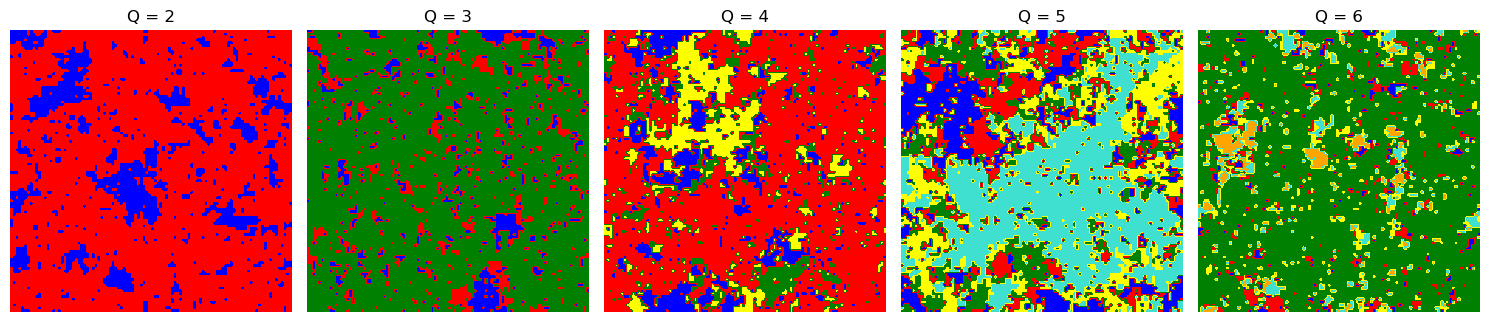

El tiempo de ejecución es de t=1643.8929619789124 segundos


In [10]:
# Prueba de transición de fase visual
inicio = time.time()
temp = [1.134, 0.994, 0.9102, 0.8515, 0.8076]
states = [2, 3, 4, 5, 6]
figuras = []
# 1. Generar figuras individuales (sin cerrarlas)

for T, Q in zip(temp, states):
    simul = PottsWolffSimulacion(L=100, q=Q, pasos_eq=30000)
    simul.ejecutar_simulacion(T)
    fig = simul.graficar_lattice(T) 
    figuras.append(fig)
# 2. Combinar en una sola figura
fig_combinada, axs = plt.subplots(1, len(figuras), figsize=(15, 5))
for ax, (fig, T, Q) in zip(axs, zip(figuras, temp, states)):
    # Extraer imagen y parámetros del colormap original
    for child in fig.get_children():
        if isinstance(child, plt.Axes):
            im = child.get_images()[0]
            break
# Usar el mismo colormap y límites que en la figura individual
    ax.imshow(im.get_array(), cmap=im.get_cmap(), vmin=im.get_clim()[0], vmax=im.get_clim()[1])
    ax.set_title(f'Q = {Q}')
    ax.axis('off')
plt.tight_layout()
plt.show()
# 4. Cerrar figuras individuales después de usarlas (opcional, para liberar memoria)
for fig in figuras:
    plt.close(fig)
fin = time.time()
print(f"El tiempo de ejecución es de t={fin-inicio} segundos")

## Estado en equilibrio para valores de $T$ y $q$ especificos

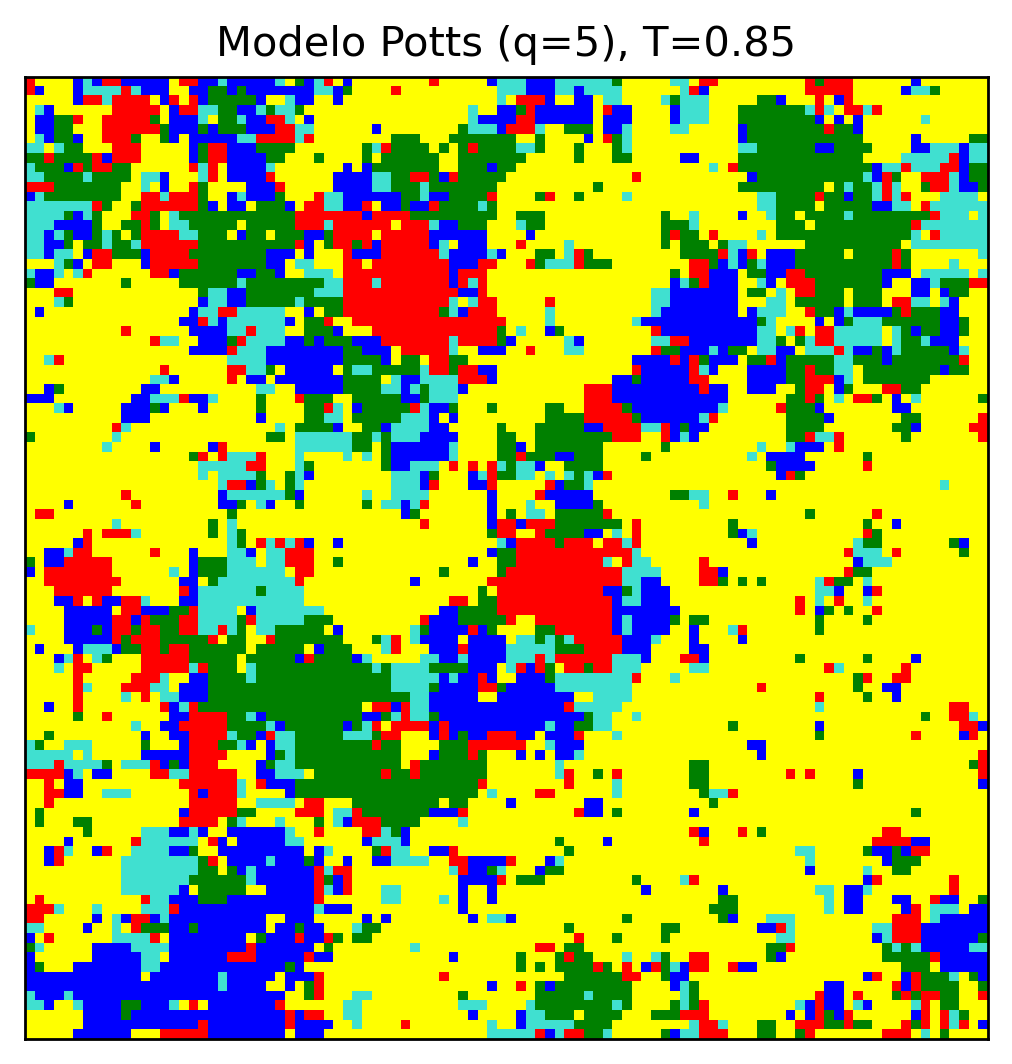

In [11]:
T = 0.8515
Q = 5
simul = PottsWolffSimulacion(L=100, q=Q, pasos_eq=30000)
simul.ejecutar_simulacion(T)
simul.graficar_lattice(T) 